In [1]:
import os

for dirname, _, filenames in os.walk('/home/du/sakib_rme/Sugarcane_Leaf_Diseaes_Classification/Dataset'):
    print(f"Directory: {dirname}")
    
    # Show up to 5 filenames
    for filename in filenames[:5]:
        print(f"    {filename}")
    
    # Print the total number of files in the directory
    print(f"    Total files: {len(filenames)}\n")

Directory: /home/du/sakib_rme/Sugarcane_Leaf_Diseaes_Classification/Dataset
    augmentation_summary.json
    Total files: 1

Directory: /home/du/sakib_rme/Sugarcane_Leaf_Diseaes_Classification/Dataset/Test_set
    Total files: 0

Directory: /home/du/sakib_rme/Sugarcane_Leaf_Diseaes_Classification/Dataset/Test_set/Sett_Rot
    Sett_Rot_00235.jpg
    Sett_Rot_00294.jpg
    Sett_Rot_00210.jpg
    Sett_Rot_00174.jpg
    Sett_Rot_00234.jpg
    Total files: 96

Directory: /home/du/sakib_rme/Sugarcane_Leaf_Diseaes_Classification/Dataset/Test_set/Mosaic
    Mosaic_00275.jpeg
    Mosaic_00317.jpeg
    Mosaic_00355.jpeg
    Mosaic_00147.jpeg
    Mosaic_00092.jpeg
    Total files: 76

Directory: /home/du/sakib_rme/Sugarcane_Leaf_Diseaes_Classification/Dataset/Test_set/Ring_Spot
    Ring_Spot_00005.jpg
    Ring_Spot_00063.jpg
    Ring_Spot_00052.jpg
    Ring_Spot_00050.jpg
    Ring_Spot_00014.jpg
    Total files: 17

Directory: /home/du/sakib_rme/Sugarcane_Leaf_Diseaes_Classification/Dataset/Test

In [2]:
import os
import random
import time
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE
from ptflops import get_model_complexity_info
import optuna
from tqdm import tqdm

In [3]:
# Data paths based on the provided file structure
BASE_DIR = '/home/du/sakib_rme/Sugarcane_Leaf_Diseaes_Classification/Dataset'
TRAIN_SET_DIR = os.path.join(BASE_DIR, 'Train_set')
AUG_SET_DIR = os.path.join(BASE_DIR, 'Augmented_Set')
TEST_SET_DIR = os.path.join(BASE_DIR, 'Test_set')

In [4]:
# Model & Training Parameters
RANDOM_STATE = 42
IMG_SIZE = 256
CROP_SIZE = 224
BATCH_SIZE = 32
N_OPTUNA_TRIALS = 20  
OPTUNA_EPOCHS = 25     
FULL_TRAIN_EPOCHS = 100
EARLY_STOPPING_PATIENCE = 10 

In [5]:
# Set random seeds for reproducibility
torch.manual_seed(RANDOM_STATE)
random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [6]:
# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
os.makedirs('./Squeezenet_outputs', exist_ok=True)

Using device: cuda


In [7]:
# --- 2. Data Loading and Preparation ---
def load_image_paths(directories):
    """Loads image paths and labels from a list of directories."""
    all_paths = []
    all_labels = []
    class_names = sorted([d for d in os.listdir(directories[0]) if os.path.isdir(os.path.join(directories[0], d))])
    class_to_int = {name: i for i, name in enumerate(class_names)}
    int_to_class = {i: name for i, name in enumerate(class_names)}

    for directory in directories:
        for class_name in class_names:
            class_dir = os.path.join(directory, class_name)
            if not os.path.isdir(class_dir):
                continue
            image_files = [os.path.join(class_dir, fname) for fname in os.listdir(class_dir) if fname.lower().endswith(('.png', '.jpg', '.jpeg'))]
            all_paths.extend(image_files)
            all_labels.extend([class_to_int[class_name]] * len(image_files))
    return all_paths, all_labels, class_to_int, int_to_class

print("--- Loading Data ---")
# Combine original train and augmented sets for the training pool
train_val_paths, train_val_labels, class_to_int, int_to_class = load_image_paths([TRAIN_SET_DIR, AUG_SET_DIR])
test_paths, test_labels, _, _ = load_image_paths([TEST_SET_DIR])
num_classes = len(class_to_int)

print(f"Found {num_classes} classes: {list(class_to_int.keys())}")

--- Loading Data ---
Found 17 classes: ['Banded_Chlorosis', 'Brown_Rust', 'Brown_Spot', 'Dried_Leaves', 'Eye_Spot', 'Grassy_Shoot', 'Healthy', 'Mosaic', 'Pokkah_Boeng', 'RedRot', 'Red_Leaf_Spot', 'Ring_Spot', 'Rust', 'Sett_Rot', 'Smut', 'Viral_Disease', 'Yellow_Leaf']


In [8]:
# Stratified split for train and validation
train_paths, val_paths, train_labels, val_labels = train_test_split(
    train_val_paths, train_val_labels, test_size=0.2, stratify=train_val_labels, random_state=RANDOM_STATE
)

print(f"Total training pool images: {len(train_val_paths)}")
print(f"Training samples: {len(train_paths)}")
print(f"Validation samples: {len(val_paths)}")
print(f"Test samples: {len(test_paths)}")

Total training pool images: 11314
Training samples: 9051
Validation samples: 2263
Test samples: 1414


In [9]:
class SugarcaneLeafDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

In [10]:
# Define transforms
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.CenterCrop(CROP_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [11]:
train_dataset = SugarcaneLeafDataset(train_paths, train_labels, transform=train_transform)
val_dataset = SugarcaneLeafDataset(val_paths, val_labels, transform=val_test_transform)
test_dataset = SugarcaneLeafDataset(test_paths, test_labels, transform=val_test_transform)

# Handle class imbalance for training loader with WeightedRandomSampler
class_counts = np.bincount(train_labels)
class_weights = 1. / class_counts
sample_weights = np.array([class_weights[label] for label in train_labels])
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

In [12]:
class RegularizedSqueezeNet(nn.Module):
    def __init__(self, num_classes, dropout_rate1=0.5, dropout_rate2=0.5, freeze_ratio=0.5):
        super().__init__()
        # Load the pretrained SqueezeNet 1.1 model and its feature extractor
        self.base_model = models.squeezenet1_1(weights=models.SqueezeNet1_1_Weights.IMAGENET1K_V1)
        self.features = self.base_model.features

        # Freeze layers in the feature extractor
        params = list(self.features.parameters())
        num_to_freeze = int(len(params) * freeze_ratio)
        for i in range(num_to_freeze):
            params[i].requires_grad = False

        # SqueezeNet 1.1's feature extractor outputs 512 channels
        in_features = 512

        # Create a new custom classifier head
        self.classifier = nn.Sequential(
            # Pool the feature map to a single vector per image
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(start_dim=1),

            # Custom classification layers
            nn.Dropout(p=dropout_rate1),
            nn.Linear(in_features, 1024),
            nn.ReLU(inplace=True),
            nn.BatchNorm1d(1024),
            nn.Dropout(p=dropout_rate2),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        # Pass input through the feature extractor and then the new classifier
        x = self.features(x)
        x = self.classifier(x)
        return x

In [13]:
def train_epoch(model, loader, criterion, optimizer, device, grad_clip_norm=1.0):
    model.train()
    running_loss = 0.0
    for data, targets in loader:
        data, targets = data.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=grad_clip_norm)
        optimizer.step()
        running_loss += loss.item() * data.size(0)
    return running_loss / len(loader.dataset)

def evaluate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    all_preds, all_targets, all_outputs = [], [], []
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * data.size(0)

            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())
            all_outputs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

    loss = running_loss / len(loader.dataset)
    accuracy = 100 * np.sum(np.array(all_preds) == np.array(all_targets)) / len(all_targets)
    return loss, accuracy, all_preds, all_targets, np.array(all_outputs)


In [14]:
def objective(trial):
    # Suggest hyperparameters
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical("optimizer", ["AdamW", "Adam"])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-2, log=True)
    dropout_rate1 = trial.suggest_float("dropout_rate1", 0.1, 0.6)
    dropout_rate2 = trial.suggest_float("dropout_rate2", 0.1, 0.6)
    freeze_ratio = trial.suggest_float("freeze_ratio", 0.0, 0.8)
    label_smoothing = trial.suggest_float("label_smoothing", 0.0, 0.2)
    grad_clip = trial.suggest_float("grad_clip", 0.5, 2.0)

    # Model, Optimizer, Criterion
    model = RegularizedSqueezeNet(num_classes, dropout_rate1, dropout_rate2, freeze_ratio).to(device)
    optimizer = getattr(torch.optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    # Training loop for the trial
    for epoch in range(OPTUNA_EPOCHS):
        train_epoch(model, train_loader, criterion, optimizer, device, grad_clip)
        val_loss, val_acc, _, _, _ = evaluate(model, val_loader, criterion, device)

        print(f"Trial {trial.number} | Epoch {epoch+1}/{OPTUNA_EPOCHS} | Val Acc: {val_acc:.2f}%")
        trial.report(val_acc, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_acc

In [15]:
print("\n--- Starting Hyperparameter Optimization with Optuna ---")
study = optuna.create_study(direction="maximize", pruner=optuna.pruners.MedianPruner())
study.optimize(objective, n_trials=N_OPTUNA_TRIALS) 

print("Number of finished trials: ", len(study.trials))
print("Best trial:")
best_trial = study.best_trial
print("  Value: {:.2f}%".format(best_trial.value))
print("  Params: ")
for key, value in best_trial.params.items():
    print("    {}: {}".format(key, value))
best_hyperparams = best_trial.params

[I 2025-07-18 15:15:30,234] A new study created in memory with name: no-name-92d6eb7e-dea3-410c-b6ab-ad35fbf107fb



--- Starting Hyperparameter Optimization with Optuna ---
Trial 0 | Epoch 1/25 | Val Acc: 53.82%
Trial 0 | Epoch 2/25 | Val Acc: 70.44%
Trial 0 | Epoch 3/25 | Val Acc: 78.17%
Trial 0 | Epoch 4/25 | Val Acc: 81.66%
Trial 0 | Epoch 5/25 | Val Acc: 85.77%
Trial 0 | Epoch 6/25 | Val Acc: 88.02%
Trial 0 | Epoch 7/25 | Val Acc: 88.73%
Trial 0 | Epoch 8/25 | Val Acc: 90.59%
Trial 0 | Epoch 9/25 | Val Acc: 90.94%
Trial 0 | Epoch 10/25 | Val Acc: 90.50%
Trial 0 | Epoch 11/25 | Val Acc: 91.60%
Trial 0 | Epoch 12/25 | Val Acc: 90.01%
Trial 0 | Epoch 13/25 | Val Acc: 91.38%
Trial 0 | Epoch 14/25 | Val Acc: 92.22%
Trial 0 | Epoch 15/25 | Val Acc: 91.74%
Trial 0 | Epoch 16/25 | Val Acc: 92.53%
Trial 0 | Epoch 17/25 | Val Acc: 92.31%
Trial 0 | Epoch 18/25 | Val Acc: 92.44%
Trial 0 | Epoch 19/25 | Val Acc: 90.50%
Trial 0 | Epoch 20/25 | Val Acc: 91.12%
Trial 0 | Epoch 21/25 | Val Acc: 91.16%
Trial 0 | Epoch 22/25 | Val Acc: 90.94%
Trial 0 | Epoch 23/25 | Val Acc: 89.88%
Trial 0 | Epoch 24/25 | Val Acc

[I 2025-07-18 15:31:32,958] Trial 0 finished with value: 89.9690676093681 and parameters: {'lr': 2.457115970985417e-05, 'optimizer': 'Adam', 'weight_decay': 0.005794249310436683, 'dropout_rate1': 0.3725308047898537, 'dropout_rate2': 0.40973662185325543, 'freeze_ratio': 0.17993000738804935, 'label_smoothing': 0.11313938196448217, 'grad_clip': 1.0847696178083641}. Best is trial 0 with value: 89.9690676093681.


Trial 0 | Epoch 25/25 | Val Acc: 89.97%
Trial 1 | Epoch 1/25 | Val Acc: 15.16%
Trial 1 | Epoch 2/25 | Val Acc: 7.29%
Trial 1 | Epoch 3/25 | Val Acc: 13.88%
Trial 1 | Epoch 4/25 | Val Acc: 9.37%
Trial 1 | Epoch 5/25 | Val Acc: 20.90%
Trial 1 | Epoch 6/25 | Val Acc: 20.46%
Trial 1 | Epoch 7/25 | Val Acc: 21.34%
Trial 1 | Epoch 8/25 | Val Acc: 24.26%
Trial 1 | Epoch 9/25 | Val Acc: 27.79%
Trial 1 | Epoch 10/25 | Val Acc: 31.99%
Trial 1 | Epoch 11/25 | Val Acc: 34.03%
Trial 1 | Epoch 12/25 | Val Acc: 27.00%
Trial 1 | Epoch 13/25 | Val Acc: 39.20%
Trial 1 | Epoch 14/25 | Val Acc: 41.01%
Trial 1 | Epoch 15/25 | Val Acc: 42.29%
Trial 1 | Epoch 16/25 | Val Acc: 43.08%
Trial 1 | Epoch 17/25 | Val Acc: 37.91%
Trial 1 | Epoch 18/25 | Val Acc: 46.97%
Trial 1 | Epoch 19/25 | Val Acc: 44.41%
Trial 1 | Epoch 20/25 | Val Acc: 51.70%
Trial 1 | Epoch 21/25 | Val Acc: 44.10%
Trial 1 | Epoch 22/25 | Val Acc: 47.59%
Trial 1 | Epoch 23/25 | Val Acc: 48.03%
Trial 1 | Epoch 24/25 | Val Acc: 48.70%


[I 2025-07-18 15:47:11,204] Trial 1 finished with value: 47.59169244365886 and parameters: {'lr': 0.0036934388515324906, 'optimizer': 'Adam', 'weight_decay': 0.001212643690810896, 'dropout_rate1': 0.45555601247364597, 'dropout_rate2': 0.4836761631032652, 'freeze_ratio': 0.4011541924201499, 'label_smoothing': 0.09567309030340124, 'grad_clip': 1.8590384299769878}. Best is trial 0 with value: 89.9690676093681.


Trial 1 | Epoch 25/25 | Val Acc: 47.59%
Trial 2 | Epoch 1/25 | Val Acc: 71.72%
Trial 2 | Epoch 2/25 | Val Acc: 82.37%
Trial 2 | Epoch 3/25 | Val Acc: 87.80%
Trial 2 | Epoch 4/25 | Val Acc: 90.85%
Trial 2 | Epoch 5/25 | Val Acc: 91.16%
Trial 2 | Epoch 6/25 | Val Acc: 92.13%
Trial 2 | Epoch 7/25 | Val Acc: 92.80%
Trial 2 | Epoch 8/25 | Val Acc: 92.31%
Trial 2 | Epoch 9/25 | Val Acc: 94.08%
Trial 2 | Epoch 10/25 | Val Acc: 93.90%
Trial 2 | Epoch 11/25 | Val Acc: 94.92%
Trial 2 | Epoch 12/25 | Val Acc: 94.03%
Trial 2 | Epoch 13/25 | Val Acc: 94.43%
Trial 2 | Epoch 14/25 | Val Acc: 94.30%
Trial 2 | Epoch 15/25 | Val Acc: 94.48%
Trial 2 | Epoch 16/25 | Val Acc: 95.71%
Trial 2 | Epoch 17/25 | Val Acc: 94.21%
Trial 2 | Epoch 18/25 | Val Acc: 95.18%
Trial 2 | Epoch 19/25 | Val Acc: 95.98%
Trial 2 | Epoch 20/25 | Val Acc: 95.36%
Trial 2 | Epoch 21/25 | Val Acc: 95.45%
Trial 2 | Epoch 22/25 | Val Acc: 96.11%
Trial 2 | Epoch 23/25 | Val Acc: 96.64%
Trial 2 | Epoch 24/25 | Val Acc: 96.51%


[I 2025-07-18 16:02:44,660] Trial 2 finished with value: 95.84622182942996 and parameters: {'lr': 9.928657048206778e-05, 'optimizer': 'AdamW', 'weight_decay': 0.0014741457820943247, 'dropout_rate1': 0.5180744017956792, 'dropout_rate2': 0.4585162640567073, 'freeze_ratio': 0.031218811252310543, 'label_smoothing': 0.015483030650382257, 'grad_clip': 1.7174349635319979}. Best is trial 2 with value: 95.84622182942996.


Trial 2 | Epoch 25/25 | Val Acc: 95.85%
Trial 3 | Epoch 1/25 | Val Acc: 8.97%
Trial 3 | Epoch 2/25 | Val Acc: 20.95%
Trial 3 | Epoch 3/25 | Val Acc: 6.72%
Trial 3 | Epoch 4/25 | Val Acc: 24.70%
Trial 3 | Epoch 5/25 | Val Acc: 23.86%
Trial 3 | Epoch 6/25 | Val Acc: 24.30%
Trial 3 | Epoch 7/25 | Val Acc: 21.65%
Trial 3 | Epoch 8/25 | Val Acc: 26.47%
Trial 3 | Epoch 9/25 | Val Acc: 16.84%
Trial 3 | Epoch 10/25 | Val Acc: 25.54%
Trial 3 | Epoch 11/25 | Val Acc: 25.54%
Trial 3 | Epoch 12/25 | Val Acc: 24.57%
Trial 3 | Epoch 13/25 | Val Acc: 32.04%
Trial 3 | Epoch 14/25 | Val Acc: 29.25%
Trial 3 | Epoch 15/25 | Val Acc: 27.40%
Trial 3 | Epoch 16/25 | Val Acc: 24.30%
Trial 3 | Epoch 17/25 | Val Acc: 22.76%
Trial 3 | Epoch 18/25 | Val Acc: 29.30%
Trial 3 | Epoch 19/25 | Val Acc: 29.03%
Trial 3 | Epoch 20/25 | Val Acc: 21.52%
Trial 3 | Epoch 21/25 | Val Acc: 25.54%
Trial 3 | Epoch 22/25 | Val Acc: 31.24%
Trial 3 | Epoch 23/25 | Val Acc: 24.66%
Trial 3 | Epoch 24/25 | Val Acc: 32.04%


[I 2025-07-18 16:17:22,572] Trial 3 finished with value: 28.36942112240389 and parameters: {'lr': 0.0022667647251757243, 'optimizer': 'Adam', 'weight_decay': 0.0017976346472252447, 'dropout_rate1': 0.4751260914311789, 'dropout_rate2': 0.14634078403590325, 'freeze_ratio': 0.07991695400950372, 'label_smoothing': 0.1604878220595698, 'grad_clip': 1.9751854624697942}. Best is trial 2 with value: 95.84622182942996.


Trial 3 | Epoch 25/25 | Val Acc: 28.37%
Trial 4 | Epoch 1/25 | Val Acc: 44.23%
Trial 4 | Epoch 2/25 | Val Acc: 54.00%
Trial 4 | Epoch 3/25 | Val Acc: 63.90%
Trial 4 | Epoch 4/25 | Val Acc: 71.54%
Trial 4 | Epoch 5/25 | Val Acc: 75.96%
Trial 4 | Epoch 6/25 | Val Acc: 77.91%
Trial 4 | Epoch 7/25 | Val Acc: 79.94%
Trial 4 | Epoch 8/25 | Val Acc: 82.68%
Trial 4 | Epoch 9/25 | Val Acc: 82.37%
Trial 4 | Epoch 10/25 | Val Acc: 84.93%
Trial 4 | Epoch 11/25 | Val Acc: 84.93%
Trial 4 | Epoch 12/25 | Val Acc: 85.64%
Trial 4 | Epoch 13/25 | Val Acc: 86.92%
Trial 4 | Epoch 14/25 | Val Acc: 87.49%
Trial 4 | Epoch 15/25 | Val Acc: 88.25%
Trial 4 | Epoch 16/25 | Val Acc: 88.69%
Trial 4 | Epoch 17/25 | Val Acc: 89.22%
Trial 4 | Epoch 18/25 | Val Acc: 89.75%
Trial 4 | Epoch 19/25 | Val Acc: 90.15%
Trial 4 | Epoch 20/25 | Val Acc: 90.50%
Trial 4 | Epoch 21/25 | Val Acc: 91.07%
Trial 4 | Epoch 22/25 | Val Acc: 91.12%
Trial 4 | Epoch 23/25 | Val Acc: 90.85%
Trial 4 | Epoch 24/25 | Val Acc: 90.94%


[I 2025-07-18 16:31:32,328] Trial 4 finished with value: 91.07379584622183 and parameters: {'lr': 1.8082734199374427e-05, 'optimizer': 'Adam', 'weight_decay': 0.0001259262107321417, 'dropout_rate1': 0.5154475234598176, 'dropout_rate2': 0.46851911539000934, 'freeze_ratio': 0.6968387734381547, 'label_smoothing': 0.09439840602227033, 'grad_clip': 1.0827748353686542}. Best is trial 2 with value: 95.84622182942996.


Trial 4 | Epoch 25/25 | Val Acc: 91.07%
Trial 5 | Epoch 1/25 | Val Acc: 75.92%
Trial 5 | Epoch 2/25 | Val Acc: 86.70%
Trial 5 | Epoch 3/25 | Val Acc: 89.31%
Trial 5 | Epoch 4/25 | Val Acc: 91.43%
Trial 5 | Epoch 5/25 | Val Acc: 91.43%
Trial 5 | Epoch 6/25 | Val Acc: 91.56%
Trial 5 | Epoch 7/25 | Val Acc: 92.80%
Trial 5 | Epoch 8/25 | Val Acc: 93.37%
Trial 5 | Epoch 9/25 | Val Acc: 93.86%
Trial 5 | Epoch 10/25 | Val Acc: 93.19%
Trial 5 | Epoch 11/25 | Val Acc: 95.36%
Trial 5 | Epoch 12/25 | Val Acc: 94.03%
Trial 5 | Epoch 13/25 | Val Acc: 95.45%
Trial 5 | Epoch 14/25 | Val Acc: 93.90%
Trial 5 | Epoch 15/25 | Val Acc: 95.32%
Trial 5 | Epoch 16/25 | Val Acc: 94.56%
Trial 5 | Epoch 17/25 | Val Acc: 96.42%
Trial 5 | Epoch 18/25 | Val Acc: 95.89%
Trial 5 | Epoch 19/25 | Val Acc: 94.61%
Trial 5 | Epoch 20/25 | Val Acc: 96.20%
Trial 5 | Epoch 21/25 | Val Acc: 96.11%
Trial 5 | Epoch 22/25 | Val Acc: 95.85%
Trial 5 | Epoch 23/25 | Val Acc: 95.93%
Trial 5 | Epoch 24/25 | Val Acc: 94.34%


[I 2025-07-18 16:44:35,120] Trial 5 finished with value: 96.11135660627485 and parameters: {'lr': 0.0001164556062327658, 'optimizer': 'Adam', 'weight_decay': 0.00028872105440295553, 'dropout_rate1': 0.527569205221063, 'dropout_rate2': 0.27907886126475057, 'freeze_ratio': 0.05067609780532889, 'label_smoothing': 0.08214038946624852, 'grad_clip': 1.4229698572072267}. Best is trial 5 with value: 96.11135660627485.


Trial 5 | Epoch 25/25 | Val Acc: 96.11%
Trial 6 | Epoch 1/25 | Val Acc: 49.54%


[I 2025-07-18 16:45:31,650] Trial 6 pruned. 


Trial 6 | Epoch 2/25 | Val Acc: 61.33%
Trial 7 | Epoch 1/25 | Val Acc: 70.39%
Trial 7 | Epoch 2/25 | Val Acc: 83.03%
Trial 7 | Epoch 3/25 | Val Acc: 86.57%
Trial 7 | Epoch 4/25 | Val Acc: 90.10%
Trial 7 | Epoch 5/25 | Val Acc: 90.01%
Trial 7 | Epoch 6/25 | Val Acc: 91.12%
Trial 7 | Epoch 7/25 | Val Acc: 92.22%
Trial 7 | Epoch 8/25 | Val Acc: 92.40%
Trial 7 | Epoch 9/25 | Val Acc: 93.86%
Trial 7 | Epoch 10/25 | Val Acc: 94.34%
Trial 7 | Epoch 11/25 | Val Acc: 94.70%
Trial 7 | Epoch 12/25 | Val Acc: 94.43%
Trial 7 | Epoch 13/25 | Val Acc: 95.32%
Trial 7 | Epoch 14/25 | Val Acc: 95.18%
Trial 7 | Epoch 15/25 | Val Acc: 94.83%
Trial 7 | Epoch 16/25 | Val Acc: 95.01%
Trial 7 | Epoch 17/25 | Val Acc: 95.85%
Trial 7 | Epoch 18/25 | Val Acc: 94.92%
Trial 7 | Epoch 19/25 | Val Acc: 96.20%
Trial 7 | Epoch 20/25 | Val Acc: 96.69%
Trial 7 | Epoch 21/25 | Val Acc: 95.54%
Trial 7 | Epoch 22/25 | Val Acc: 96.29%
Trial 7 | Epoch 23/25 | Val Acc: 96.24%
Trial 7 | Epoch 24/25 | Val Acc: 96.29%


[I 2025-07-18 16:57:23,512] Trial 7 finished with value: 96.90676093680955 and parameters: {'lr': 8.0028253280212e-05, 'optimizer': 'AdamW', 'weight_decay': 3.881529375977827e-06, 'dropout_rate1': 0.3630310862800107, 'dropout_rate2': 0.5926126220323484, 'freeze_ratio': 0.13087532295542179, 'label_smoothing': 0.14058913690379035, 'grad_clip': 1.6857626918996313}. Best is trial 7 with value: 96.90676093680955.


Trial 7 | Epoch 25/25 | Val Acc: 96.91%
Trial 8 | Epoch 1/25 | Val Acc: 54.93%


[I 2025-07-18 16:58:19,087] Trial 8 pruned. 


Trial 8 | Epoch 2/25 | Val Acc: 62.48%
Trial 9 | Epoch 1/25 | Val Acc: 77.55%
Trial 9 | Epoch 2/25 | Val Acc: 82.28%
Trial 9 | Epoch 3/25 | Val Acc: 84.49%
Trial 9 | Epoch 4/25 | Val Acc: 90.15%
Trial 9 | Epoch 5/25 | Val Acc: 92.93%
Trial 9 | Epoch 6/25 | Val Acc: 91.83%
Trial 9 | Epoch 7/25 | Val Acc: 93.37%
Trial 9 | Epoch 8/25 | Val Acc: 93.42%
Trial 9 | Epoch 9/25 | Val Acc: 93.95%
Trial 9 | Epoch 10/25 | Val Acc: 94.79%
Trial 9 | Epoch 11/25 | Val Acc: 94.17%
Trial 9 | Epoch 12/25 | Val Acc: 95.01%
Trial 9 | Epoch 13/25 | Val Acc: 92.31%
Trial 9 | Epoch 14/25 | Val Acc: 94.48%
Trial 9 | Epoch 15/25 | Val Acc: 93.50%
Trial 9 | Epoch 16/25 | Val Acc: 92.62%
Trial 9 | Epoch 17/25 | Val Acc: 94.56%
Trial 9 | Epoch 18/25 | Val Acc: 93.73%
Trial 9 | Epoch 19/25 | Val Acc: 95.01%
Trial 9 | Epoch 20/25 | Val Acc: 95.54%
Trial 9 | Epoch 21/25 | Val Acc: 93.59%
Trial 9 | Epoch 22/25 | Val Acc: 95.76%
Trial 9 | Epoch 23/25 | Val Acc: 95.27%
Trial 9 | Epoch 24/25 | Val Acc: 94.65%


[I 2025-07-18 17:10:12,216] Trial 9 finished with value: 94.12284577993813 and parameters: {'lr': 0.0004789354637981157, 'optimizer': 'Adam', 'weight_decay': 0.0002027865427451057, 'dropout_rate1': 0.24434206450831927, 'dropout_rate2': 0.14800390093516577, 'freeze_ratio': 0.6181033072056582, 'label_smoothing': 0.14351588611929952, 'grad_clip': 1.9294423975012214}. Best is trial 7 with value: 96.90676093680955.


Trial 9 | Epoch 25/25 | Val Acc: 94.12%


[I 2025-07-18 17:10:40,259] Trial 10 pruned. 


Trial 10 | Epoch 1/25 | Val Acc: 54.88%
Trial 11 | Epoch 1/25 | Val Acc: 77.91%
Trial 11 | Epoch 2/25 | Val Acc: 84.05%
Trial 11 | Epoch 3/25 | Val Acc: 88.78%
Trial 11 | Epoch 4/25 | Val Acc: 90.50%
Trial 11 | Epoch 5/25 | Val Acc: 92.22%
Trial 11 | Epoch 6/25 | Val Acc: 93.11%
Trial 11 | Epoch 7/25 | Val Acc: 93.15%
Trial 11 | Epoch 8/25 | Val Acc: 92.05%
Trial 11 | Epoch 9/25 | Val Acc: 94.30%
Trial 11 | Epoch 10/25 | Val Acc: 95.32%
Trial 11 | Epoch 11/25 | Val Acc: 95.32%
Trial 11 | Epoch 12/25 | Val Acc: 95.01%
Trial 11 | Epoch 13/25 | Val Acc: 95.40%
Trial 11 | Epoch 14/25 | Val Acc: 95.85%
Trial 11 | Epoch 15/25 | Val Acc: 95.10%
Trial 11 | Epoch 16/25 | Val Acc: 95.89%
Trial 11 | Epoch 17/25 | Val Acc: 95.67%
Trial 11 | Epoch 18/25 | Val Acc: 95.54%
Trial 11 | Epoch 19/25 | Val Acc: 96.16%
Trial 11 | Epoch 20/25 | Val Acc: 96.20%
Trial 11 | Epoch 21/25 | Val Acc: 96.16%
Trial 11 | Epoch 22/25 | Val Acc: 96.24%
Trial 11 | Epoch 23/25 | Val Acc: 95.89%
Trial 11 | Epoch 24/25 | V

[I 2025-07-18 17:22:35,889] Trial 11 finished with value: 96.5974370304905 and parameters: {'lr': 9.894523090991564e-05, 'optimizer': 'AdamW', 'weight_decay': 1.7540385743775472e-06, 'dropout_rate1': 0.3947729500343047, 'dropout_rate2': 0.30360317168720147, 'freeze_ratio': 0.3395627360403083, 'label_smoothing': 0.04994532424298237, 'grad_clip': 1.4281717988269018}. Best is trial 7 with value: 96.90676093680955.


Trial 11 | Epoch 25/25 | Val Acc: 96.60%
Trial 12 | Epoch 1/25 | Val Acc: 77.20%
Trial 12 | Epoch 2/25 | Val Acc: 85.51%
Trial 12 | Epoch 3/25 | Val Acc: 84.93%
Trial 12 | Epoch 4/25 | Val Acc: 91.12%
Trial 12 | Epoch 5/25 | Val Acc: 93.24%
Trial 12 | Epoch 6/25 | Val Acc: 93.37%
Trial 12 | Epoch 7/25 | Val Acc: 93.37%
Trial 12 | Epoch 8/25 | Val Acc: 94.48%
Trial 12 | Epoch 9/25 | Val Acc: 95.01%
Trial 12 | Epoch 10/25 | Val Acc: 93.99%
Trial 12 | Epoch 11/25 | Val Acc: 95.32%
Trial 12 | Epoch 12/25 | Val Acc: 93.42%
Trial 12 | Epoch 13/25 | Val Acc: 96.02%
Trial 12 | Epoch 14/25 | Val Acc: 96.24%
Trial 12 | Epoch 15/25 | Val Acc: 95.54%
Trial 12 | Epoch 16/25 | Val Acc: 95.93%
Trial 12 | Epoch 17/25 | Val Acc: 96.38%
Trial 12 | Epoch 18/25 | Val Acc: 96.29%
Trial 12 | Epoch 19/25 | Val Acc: 95.67%
Trial 12 | Epoch 20/25 | Val Acc: 95.71%
Trial 12 | Epoch 21/25 | Val Acc: 95.36%
Trial 12 | Epoch 22/25 | Val Acc: 96.91%
Trial 12 | Epoch 23/25 | Val Acc: 96.51%
Trial 12 | Epoch 24/25 | 

[I 2025-07-18 17:34:26,998] Trial 12 finished with value: 96.5974370304905 and parameters: {'lr': 9.65997013182134e-05, 'optimizer': 'AdamW', 'weight_decay': 1.044860770759759e-06, 'dropout_rate1': 0.3857451333698642, 'dropout_rate2': 0.3192540157828518, 'freeze_ratio': 0.34259919817392304, 'label_smoothing': 0.044268949568158245, 'grad_clip': 1.4729030374372374}. Best is trial 7 with value: 96.90676093680955.


Trial 12 | Epoch 25/25 | Val Acc: 96.60%


[I 2025-07-18 17:34:55,720] Trial 13 pruned. 


Trial 13 | Epoch 1/25 | Val Acc: 64.74%
Trial 14 | Epoch 1/25 | Val Acc: 79.14%
Trial 14 | Epoch 2/25 | Val Acc: 84.98%
Trial 14 | Epoch 3/25 | Val Acc: 83.78%


[I 2025-07-18 17:36:48,297] Trial 14 pruned. 


Trial 14 | Epoch 4/25 | Val Acc: 89.13%


[I 2025-07-18 17:37:16,097] Trial 15 pruned. 


Trial 15 | Epoch 1/25 | Val Acc: 51.30%


[I 2025-07-18 17:37:44,980] Trial 16 pruned. 


Trial 16 | Epoch 1/25 | Val Acc: 7.95%


[I 2025-07-18 17:38:13,721] Trial 17 pruned. 


Trial 17 | Epoch 1/25 | Val Acc: 68.40%


[I 2025-07-18 17:38:42,443] Trial 18 pruned. 


Trial 18 | Epoch 1/25 | Val Acc: 70.44%


[I 2025-07-18 17:39:11,267] Trial 19 pruned. 


Trial 19 | Epoch 1/25 | Val Acc: 68.49%
Number of finished trials:  20
Best trial:
  Value: 96.91%
  Params: 
    lr: 8.0028253280212e-05
    optimizer: AdamW
    weight_decay: 3.881529375977827e-06
    dropout_rate1: 0.3630310862800107
    dropout_rate2: 0.5926126220323484
    freeze_ratio: 0.13087532295542179
    label_smoothing: 0.14058913690379035
    grad_clip: 1.6857626918996313


In [16]:
# --- 7. Final Model Training ---
print("\n--- Starting Final Training with Best Hyperparameters ---")
final_model = RegularizedSqueezeNet(
    num_classes=num_classes,
    dropout_rate1=best_hyperparams["dropout_rate1"],
    dropout_rate2=best_hyperparams["dropout_rate2"],
    freeze_ratio=best_hyperparams["freeze_ratio"]
).to(device)

final_optimizer = getattr(torch.optim, best_hyperparams["optimizer"])(
    final_model.parameters(), lr=best_hyperparams["lr"], weight_decay=best_hyperparams["weight_decay"]
)
final_criterion = nn.CrossEntropyLoss(label_smoothing=best_hyperparams["label_smoothing"])
final_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(final_optimizer, T_max=FULL_TRAIN_EPOCHS)


--- Starting Final Training with Best Hyperparameters ---


In [17]:
# Calculate and print model complexity
try:
    macs, params = get_model_complexity_info(final_model, (3, CROP_SIZE, CROP_SIZE), as_strings=True, print_per_layer_stat=False, verbose=False)
    print(f"\nFinal Model Complexity: MACs: {macs}, Params: {params}")
except Exception as e:
    print(f"Could not calculate model complexity: {e}")


Final Model Complexity: MACs: 542.16 MMac, Params: 1.78 M


In [18]:
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_loss = float('inf')
epochs_no_improve = 0
training_start_time = time.time()

In [19]:
for epoch in range(FULL_TRAIN_EPOCHS):
    train_loss = train_epoch(final_model, train_loader, final_criterion, final_optimizer, device, best_hyperparams["grad_clip"])
    _, train_acc, _, _, _ = evaluate(final_model, train_loader, final_criterion, device)
    val_loss, val_acc, _, _, _ = evaluate(final_model, val_loader, final_criterion, device)

    final_scheduler.step()

    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f'Epoch {epoch+1}/{FULL_TRAIN_EPOCHS} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(final_model.state_dict(), './Squeezenet_outputs/best_model.pth')
        print("  Validation loss decreased. Model saved.")
    else:
        epochs_no_improve += 1

    if epochs_no_improve >= EARLY_STOPPING_PATIENCE:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
        break

total_training_duration = time.time() - training_start_time
print(f"Total final training time: {total_training_duration/60:.2f} minutes.")

Epoch 1/100 | Train Loss: 2.1485, Acc: 73.34% | Val Loss: 1.5039, Acc: 70.17%
  Validation loss decreased. Model saved.
Epoch 2/100 | Train Loss: 1.5034, Acc: 85.13% | Val Loss: 1.3147, Acc: 81.66%
  Validation loss decreased. Model saved.
Epoch 3/100 | Train Loss: 1.2901, Acc: 91.22% | Val Loss: 1.1659, Acc: 87.27%
  Validation loss decreased. Model saved.
Epoch 4/100 | Train Loss: 1.1943, Acc: 92.56% | Val Loss: 1.1113, Acc: 88.64%
  Validation loss decreased. Model saved.
Epoch 5/100 | Train Loss: 1.1176, Acc: 94.09% | Val Loss: 1.0791, Acc: 90.19%
  Validation loss decreased. Model saved.
Epoch 6/100 | Train Loss: 1.0702, Acc: 96.16% | Val Loss: 1.0515, Acc: 91.83%
  Validation loss decreased. Model saved.
Epoch 7/100 | Train Loss: 1.0441, Acc: 96.59% | Val Loss: 1.0221, Acc: 92.97%
  Validation loss decreased. Model saved.
Epoch 8/100 | Train Loss: 1.0093, Acc: 97.46% | Val Loss: 1.0040, Acc: 93.19%
  Validation loss decreased. Model saved.
Epoch 9/100 | Train Loss: 0.9939, Acc: 9

In [20]:
print("\n--- Final Evaluation on Test Set ---")
# Load the best model
best_model = RegularizedSqueezeNet(
    num_classes=num_classes,
    dropout_rate1=best_hyperparams["dropout_rate1"],
    dropout_rate2=best_hyperparams["dropout_rate2"],
    freeze_ratio=best_hyperparams["freeze_ratio"]
).to(device)
best_model.load_state_dict(torch.load('./Squeezenet_outputs/best_model.pth', map_location=device))


--- Final Evaluation on Test Set ---


<All keys matched successfully>

In [21]:
# Evaluate on test set
inference_start_time = time.time()
test_loss, test_acc, test_preds, test_targets, test_outputs = evaluate(best_model, test_loader, final_criterion, device)
inference_duration = time.time() - inference_start_time
avg_inference_time = (inference_duration / len(test_dataset)) * 1000

print(f"Test Set Performance: Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}%")
print(f"Average inference time per image: {avg_inference_time:.2f} ms")

# Get class names in correct order for reports
class_names_report = [int_to_class[i] for i in range(num_classes)]

Test Set Performance: Loss: 0.8406, Accuracy: 97.31%
Average inference time per image: 2.69 ms


In [22]:
# b) Classification Report
report = classification_report(test_targets, test_preds, target_names=class_names_report, zero_division=0)
print("\nClassification Report (Test Set):\n", report)
with open("./Squeezenet_outputs/classification_report.txt", "w") as f:
    f.write(report)


Classification Report (Test Set):
                   precision    recall  f1-score   support

Banded_Chlorosis       1.00      0.97      0.98        59
      Brown_Rust       0.97      0.97      0.97        33
      Brown_Spot       0.96      1.00      0.98       204
    Dried_Leaves       1.00      1.00      1.00        37
        Eye_Spot       0.88      1.00      0.94        15
    Grassy_Shoot       1.00      1.00      1.00        58
         Healthy       0.98      0.98      0.98       186
          Mosaic       0.91      0.91      0.91        76
    Pokkah_Boeng       0.96      1.00      0.98        46
          RedRot       1.00      0.97      0.98       147
   Red_Leaf_Spot       1.00      0.78      0.88         9
       Ring_Spot       1.00      1.00      1.00        17
            Rust       0.93      0.99      0.96        89
        Sett_Rot       1.00      1.00      1.00        96
            Smut       1.00      0.97      0.98        30
   Viral_Disease       0.99      0.

Saved confusion matrix to ./Squeezenet_outputs/confusion_matrix.png


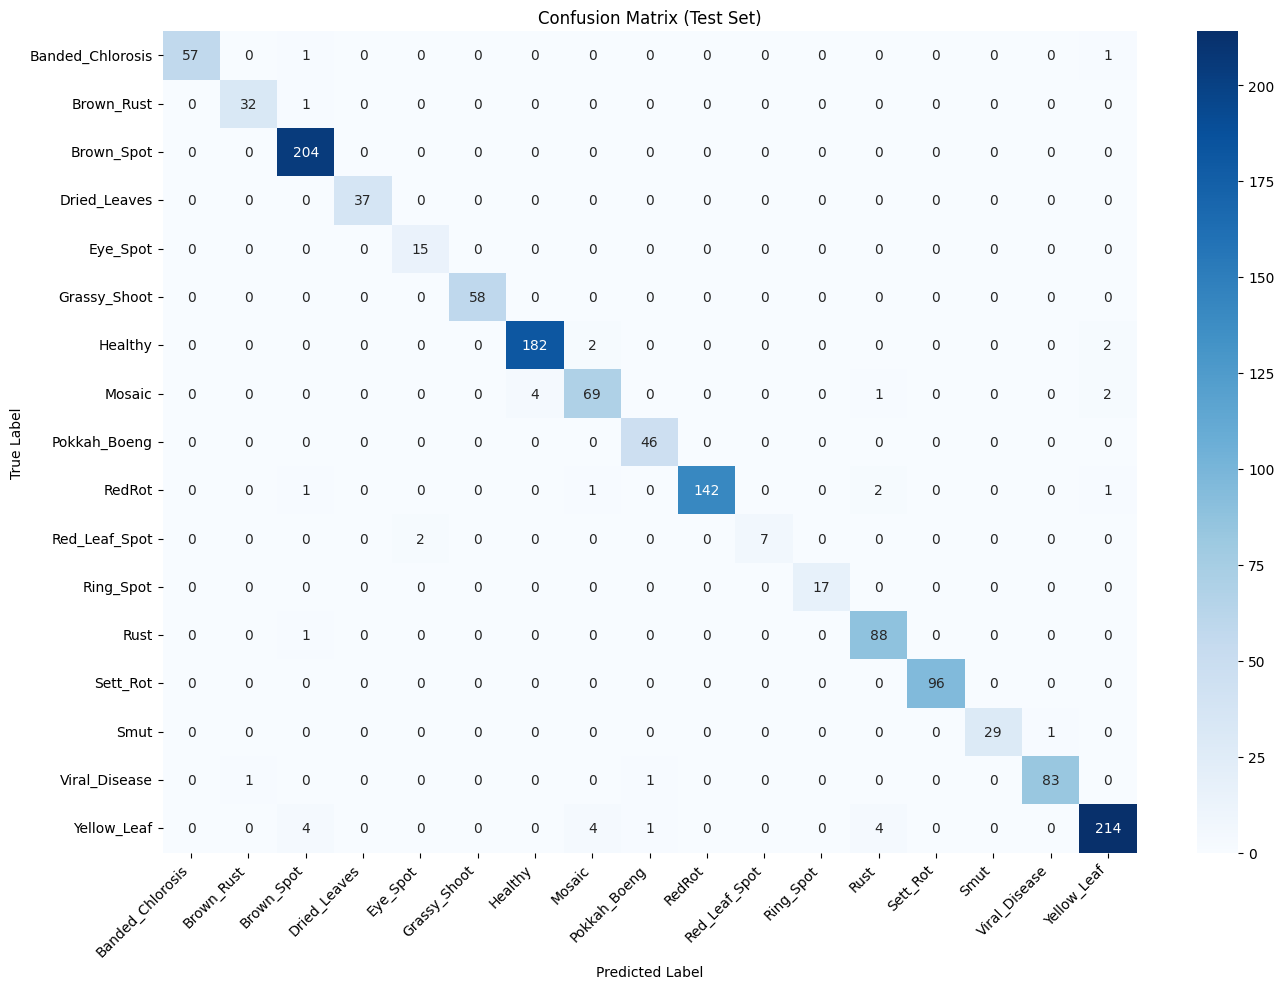

In [23]:
# c) Confusion Matrix
plt.figure(figsize=(14, 10))
cm = confusion_matrix(test_targets, test_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_report, yticklabels=class_names_report)
plt.title('Confusion Matrix (Test Set)'); plt.ylabel('True Label'); plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('./Squeezenet_outputs/confusion_matrix.png')
print("Saved confusion matrix to ./Squeezenet_outputs/confusion_matrix.png")

Saved ROC-AUC curve to ./Squeezenet_outputs/roc_auc_curve.png


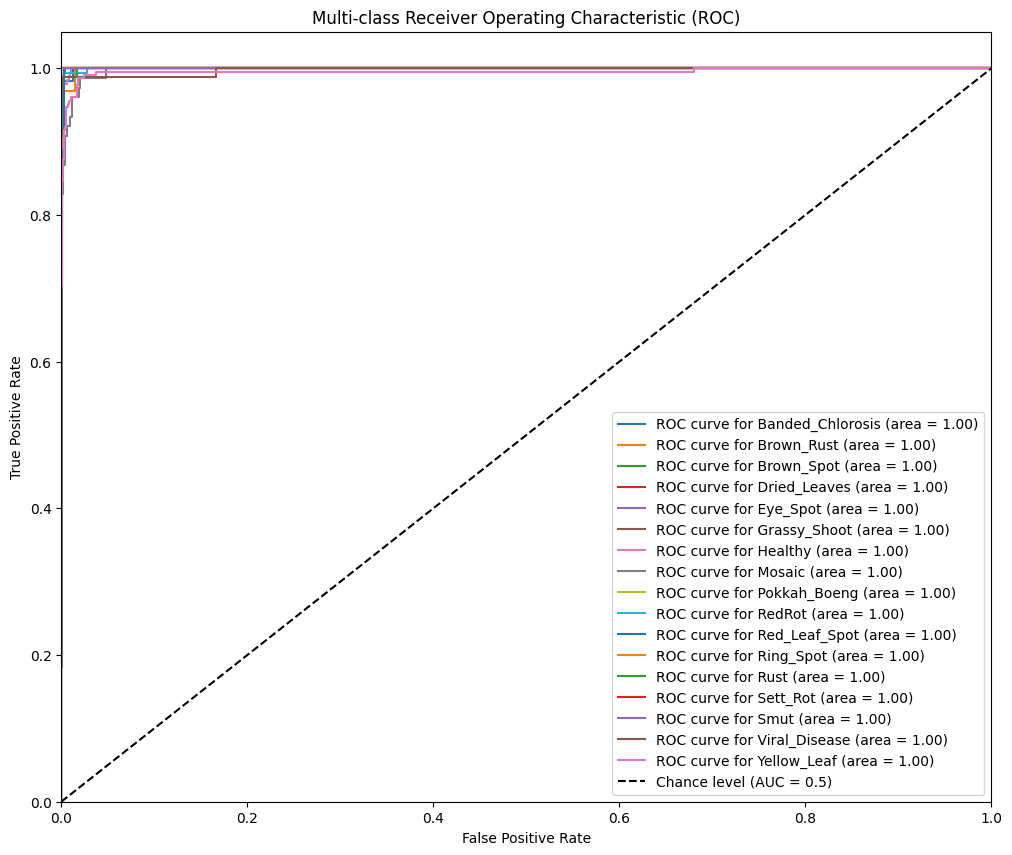

In [24]:
# Binarize labels for multi-class ROC/PR curves
y_true_bin = label_binarize(test_targets, classes=range(num_classes))

# d) ROC-AUC Curve
plt.figure(figsize=(12, 10))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], test_outputs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve for {class_names_report[i]} (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Chance level (AUC = 0.5)')
plt.xlim([0.0, 1.0]); plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('Multi-class Receiver Operating Characteristic (ROC)'); plt.legend(loc="lower right")
plt.savefig('./Squeezenet_outputs/roc_auc_curve.png')
print("Saved ROC-AUC curve to ./Squeezenet_outputs/roc_auc_curve.png")

Saved Precision-Recall curve to ./Squeezenet_outputs/precision_recall_curve.png


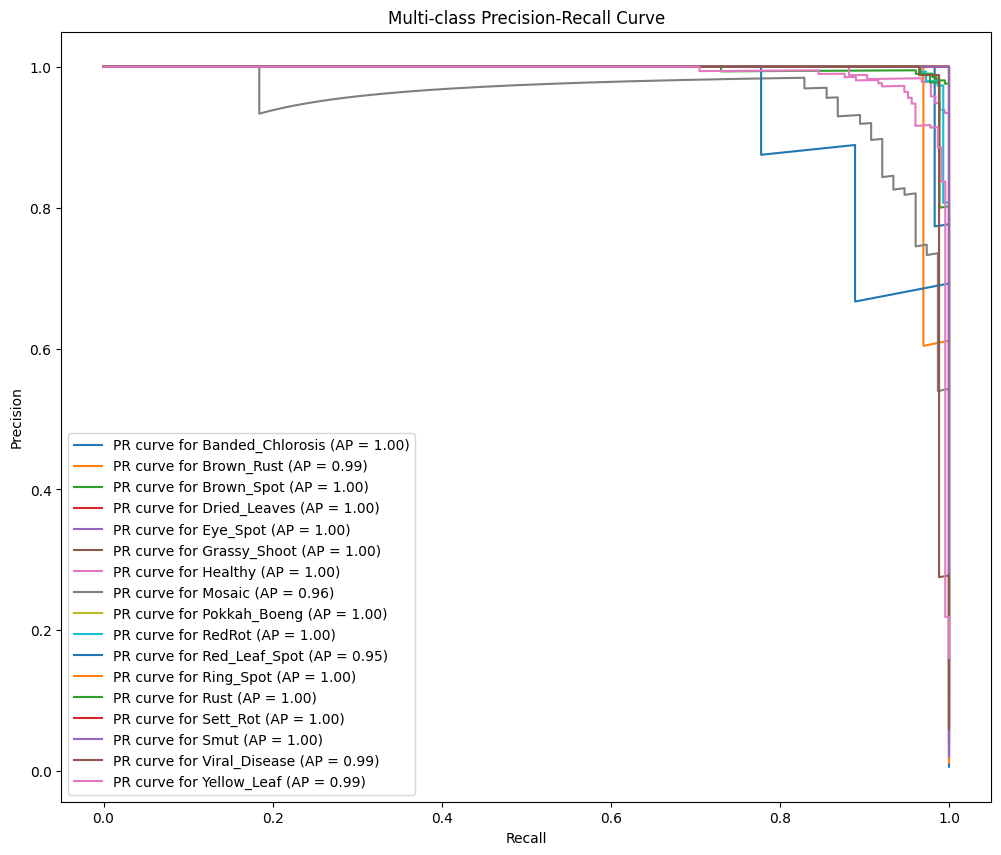

In [25]:
# e) Precision-Recall Curve
plt.figure(figsize=(12, 10))
for i in range(num_classes):
    precision, recall, _ = precision_recall_curve(y_true_bin[:, i], test_outputs[:, i])
    avg_precision = average_precision_score(y_true_bin[:, i], test_outputs[:, i])
    plt.plot(recall, precision, label=f'PR curve for {class_names_report[i]} (AP = {avg_precision:.2f})')
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Multi-class Precision-Recall Curve'); plt.legend(loc="best")
plt.savefig('./Squeezenet_outputs/precision_recall_curve.png')
print("Saved Precision-Recall curve to ./Squeezenet_outputs/precision_recall_curve.png")